<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/grammatically_correct_sentence/CoLA%20with%20DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [1]:
!pip install transformers
!pip install wget

     |████████████████████████████████| 778kB 4.5MB/s 
     |████████████████████████████████| 890kB 25.1MB/s 
     |████████████████████████████████| 1.1MB 36.6MB/s 
     |████████████████████████████████| 3.0MB 48.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=130ad7362244948ca6686c995d3e1f3fa94918b6868260757613c065bb128257
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e4acb0340e7dde2ae15737f894e369e455ecf2c496c0768682de815594bffc06
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### CoLA (Corpus of Linguistic Acceptability) Dataset

In [2]:
import os
import wget

print('Downloading dataset')
# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [3]:
if not os.path.exists('./cola_public'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [4]:
!ls

cola_public  cola_public_1.1.zip  sample_data


### Imports

In [56]:
import time

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [7]:
train_file = "cola_public/raw/in_domain_train.tsv"
test_file = "cola_public/raw/in_domain_dev.tsv"

In [8]:
df_train = pd.read_csv(train_file, sep='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_valid = pd.read_csv(test_file, sep='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

### Data Analysis

In [9]:
df_train.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [10]:
df_train = df_train.drop(columns=['sentence_source', 'label_notes'])
df_train.head()

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.


In [11]:
df_valid = df_valid.drop(columns=['sentence_source', 'label_notes'])

In [12]:
df_train.shape, df_valid.shape

((8551, 2), (527, 2))

In [13]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,label,sentence
0,1,Angela characterized Shelly as a lifesaver.
1,1,They're not finding it a stress being in the s...
2,0,Paul exhaled on Mary.
3,0,I ordered if John drink his beer.
4,1,Press the stamp against the pad completely.


Text(0.5, 0, 'Training Data Distribution')

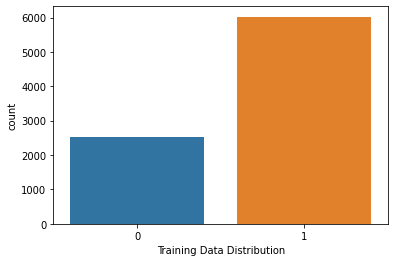

In [14]:
sns.countplot(df_train['label'].values)
plt.xlabel("Training Data Distribution")

Text(0.5, 0, 'Testing Data Distribution')

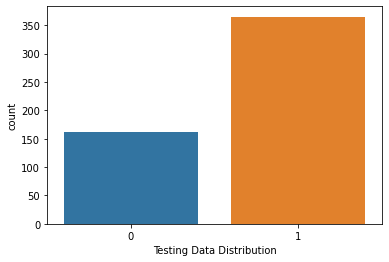

In [15]:
sns.countplot(df_valid['label'].values)
plt.xlabel("Testing Data Distribution")

#### Choosing maximum sequence length

In [ ]:
token_lens = []
for txt in df_train.sentence:
  tokens = txt.split()
  token_lens.append(len(tokens))

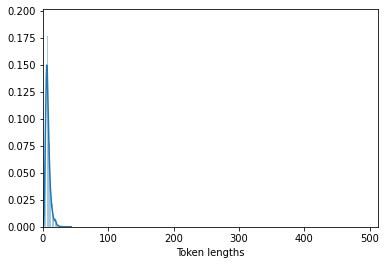

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token lengths');

### Configurations

In [16]:
OUTPUT_DIM = 1

MAX_LEN = 100

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8

EPOCHS = 3

TEACHER_MODEL_NAME = "bert-base-uncased"
STUDENT_MODEL_NAME = "distilbert-base-uncased"

TEACHER_MODEL_PATH = "teacher_model.bin"
STUDENTSA_MODEL_PATH = "studentsa_model.bin"
STUDENT_MODEL_PATH = "student_model.bin"

TOKENIZER = transformers.BertTokenizer.from_pretrained(TEACHER_MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### CoLA Dataset

In [17]:
class CoLADataset:
    def __init__(self, sentences, labels):
        
        self.sentences = sentences
        self.labels = labels

        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt',
        )

        return {
            "ids": encoding["input_ids"].flatten(),
            "mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(label, dtype=torch.float)
        }

In [18]:
train_dataset = CoLADataset(
    sentences=df_train.sentence.values,
    labels=df_train.label.values
)

valid_dataset = CoLADataset(
    sentences=df_valid.sentence.values,
    labels=df_valid.label.values
)

### DataLoaders

In [19]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    TRAIN_BATCH_SIZE,
    shuffle=True
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    VALID_BATCH_SIZE
)

In [20]:
sample = next(iter(train_data_loader))
sample["ids"].shape, sample["mask"].shape, sample["targets"].shape

(torch.Size([8, 100]), torch.Size([8, 100]), torch.Size([8]))

## BERT Model (Teacher)

In [21]:
class BERTModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.bert = transformers.BertModel.from_pretrained(TEACHER_MODEL_NAME)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, OUTPUT_DIM)
    
    def forward(self, ids, mask):
        _, o2 = self.bert(ids, attention_mask=mask)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

In [22]:
teacher_model = BERTModel()
teacher_model.to(device)

BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

### Optimizer

In [23]:
# create parameters we want to optimize
# we generally dont use any decay for bias and weight layers

param_optimizer = list(teacher_model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay) 
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0
    }
]

In [24]:
num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
num_train_steps

3206

In [25]:
optimizer = AdamW(optimizer_parameters, lr=3e-5)

### Scheduler

In [26]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

### Loss Criterion

In [27]:
criterion = nn.BCEWithLogitsLoss().to(device)

### Training Method

In [28]:
def train_fn(data_loader, model, optimizer, criterion, device, scheduler):
    model.train()
    epoch_loss = 0

    for batch in data_loader:
        ids = batch['ids'].to(device)
        mask = batch["mask"].to(device)
        targets = batch["targets"].to(device)

        optimizer.zero_grad()

        outputs = model(
            ids=ids,
            mask=mask
        )

        loss = criterion(outputs, targets.view(-1, 1))
        
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return epoch_loss / len(data_loader)

### Evaluation Method

In [29]:
def eval_fn(data_loader, model, criterion, device):
    model.eval()

    fin_outputs = []
    fin_targets = []
    epoch_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(
                ids=ids,
                mask=mask
            )

            loss = criterion(outputs, targets.view(-1, 1))
            epoch_loss += loss.item()

            targets = targets.cpu().detach()
            fin_targets.extend(targets.numpy().tolist())

            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs.numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, outputs)
    mat_cor = metrics.matthews_corrcoef(fin_targets, outputs)
    return epoch_loss / len(data_loader), accuracy, mat_cor

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

In [31]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_fn(train_data_loader, teacher_model, optimizer, criterion, device, scheduler)
    val_loss, val_acc, val_mat_cor = eval_fn(valid_data_loader, teacher_model, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(teacher_model.state_dict(), TEACHER_MODEL_PATH)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\t Train Loss: {train_loss:.3f}")
    print(f"\t Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc * 100:.2f} | Matthews Cor: {val_mat_cor:.3f}")

Epoch: 01 | Epoch Time: 1m 55s
	 Train Loss: 0.490
	 Valid Loss: 0.362 | Valid Acc: 84.06 | Matthews Cor: 0.615
Epoch: 02 | Epoch Time: 1m 54s
	 Train Loss: 0.245
	 Valid Loss: 0.427 | Valid Acc: 82.54 | Matthews Cor: 0.569
Epoch: 03 | Epoch Time: 1m 55s
	 Train Loss: 0.111
	 Valid Loss: 0.494 | Valid Acc: 83.11 | Matthews Cor: 0.584


In [32]:
teacher_model.load_state_dict(torch.load(TEACHER_MODEL_PATH))

<All keys matched successfully>

### Inference

In [33]:
def inference(sentence, model, device):
    encoded = TOKENIZER.encode_plus(
        sentence,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt',
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    prediction = torch.round(torch.sigmoid(output))
    print(f'Sentence: {sentence}')
    print(f'Grammatically Correct: {prediction.item()}')

In [34]:
sentence = "I like coding"
inference(sentence, teacher_model, device)

Sentence: I like coding
Grammatically Correct: 1.0


In [35]:
sentence = "I myself talking to"
inference(sentence, teacher_model, device)

Sentence: I myself talking to
Grammatically Correct: 0.0


In [36]:
sentence = "I am talking to myself"
inference(sentence, teacher_model, device)

Sentence: I am talking to myself
Grammatically Correct: 1.0


In [152]:
torch.cuda.empty_cache()

## DistilBERT Model (Standalone)

Without any teacher forcing from BERT Model

In [153]:
class DistilBERTModelSA(nn.Module):
    def __init__(self):
        super().__init__()

        self.bert = transformers.DistilBertModel.from_pretrained(STUDENT_MODEL_NAME)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, OUTPUT_DIM)
    
    def forward(self, ids, mask):
        output = self.bert(ids, attention_mask=mask)
        hidden = output[0]
        bo = self.bert_drop(hidden[:, 0])
        output = self.out(bo)
        return output

In [154]:
student_model_sa = DistilBERTModelSA()
student_model_sa.to(device)

DistilBERTModelSA(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

In [155]:
param_optimizer = list(student_model_sa.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay) 
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0
    }
]

In [156]:
num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
num_train_steps

3206

In [157]:
optimizer = AdamW(optimizer_parameters, lr=3e-5)

In [158]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

In [159]:
criterion = nn.BCEWithLogitsLoss().to(device)

In [160]:
def train_fn(data_loader, model, optimizer, criterion, device, scheduler):
    model.train()
    epoch_loss = 0

    for batch in data_loader:
        ids = batch['ids'].to(device)
        mask = batch["mask"].to(device)
        targets = batch["targets"].to(device)

        optimizer.zero_grad()

        outputs = model(
            ids=ids,
            mask=mask
        )

        loss = criterion(outputs, targets.view(-1, 1))
        
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return epoch_loss / len(data_loader)

In [161]:
def eval_fn(data_loader, model, criterion, device):
    model.eval()

    fin_outputs = []
    fin_targets = []
    epoch_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(
                ids=ids,
                mask=mask
            )

            loss = criterion(outputs, targets.view(-1, 1))
            epoch_loss += loss.item()

            targets = targets.cpu().detach()
            fin_targets.extend(targets.numpy().tolist())

            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs.numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, outputs)
    mat_cor = metrics.matthews_corrcoef(fin_targets, outputs)
    return epoch_loss / len(data_loader), accuracy, mat_cor

In [162]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [163]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_fn(train_data_loader, student_model_sa, optimizer, criterion, device, scheduler)
    val_loss, val_acc, val_mat_cor = eval_fn(valid_data_loader, student_model_sa, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(student_model_sa.state_dict(), STUDENTSA_MODEL_PATH)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\t Train Loss: {train_loss:.3f}")
    print(f"\t Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc * 100:.2f} | Matthews Cor: {val_mat_cor:.3f}")

Epoch: 01 | Epoch Time: 1m 1s
	 Train Loss: 0.528
	 Valid Loss: 0.458 | Valid Acc: 77.99 | Matthews Cor: 0.450
Epoch: 02 | Epoch Time: 1m 1s
	 Train Loss: 0.292
	 Valid Loss: 0.467 | Valid Acc: 80.65 | Matthews Cor: 0.523
Epoch: 03 | Epoch Time: 1m 1s
	 Train Loss: 0.132
	 Valid Loss: 0.576 | Valid Acc: 82.54 | Matthews Cor: 0.570


In [164]:
student_model_sa.load_state_dict(torch.load(STUDENTSA_MODEL_PATH))

<All keys matched successfully>

In [165]:
def inference(sentence, model, device):
    encoded = TOKENIZER.encode_plus(
        sentence,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt',
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    prediction = torch.round(torch.sigmoid(output))
    print(f'Sentence: {sentence}')
    print(f'Grammatically Correct: {prediction.item()}')

In [166]:
sentence = "I like coding"
inference(sentence, student_model_sa, device)

Sentence: I like coding
Grammatically Correct: 1.0


In [263]:
torch.cuda.empty_cache()

## DistilBERT Model (With Teacher Forcing)

In [264]:
class DistilBERTModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.bert = transformers.DistilBertModel.from_pretrained(STUDENT_MODEL_NAME)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, OUTPUT_DIM)
    
    def forward(self, ids, mask):
        output = self.bert(ids, attention_mask=mask)
        hidden = output[0]
        bo = self.bert_drop(hidden[:, 0])
        output = self.out(bo)
        return output

In [265]:
student_model = DistilBERTModel()
student_model.to(device)

DistilBERTModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_fea

In [266]:
param_optimizer = list(student_model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay) 
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0
    }
]

In [267]:
num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
num_train_steps

3206

In [268]:
optimizer = AdamW(optimizer_parameters, lr=3e-5)

In [269]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

In [270]:
criterion = nn.BCEWithLogitsLoss().to(device)
MSE_loss = nn.MSELoss(reduction='mean')
KLD_loss = nn.KLDivLoss(reduction="batchmean")

In [271]:
def train_fn(data_loader, model, teacher_model, optimizer, criterion, device, scheduler, alpha_clf=1.0, alpha_teacher=1.0, temperature=2.0):
    model.train()
    epoch_clf_loss = 0
    epoch_total_loss = 0

    for batch in data_loader:
        ids = batch['ids'].to(device)
        mask = batch["mask"].to(device)
        targets = batch["targets"].to(device)

        optimizer.zero_grad()

        student_logits = model(
            ids=ids,
            mask=mask
        )

        with torch.no_grad():
            teacher_logits = teacher_model(
                ids=ids,
                mask=mask
            )
        
        mse_loss = MSE_loss(student_logits, teacher_logits)
        kld_loss = KLD_loss(
                    (student_logits / temperature),
                    (teacher_logits / temperature),
                ) 
        clf_loss = criterion(student_logits, targets.view(-1, 1))
        teacher_loss = mse_loss + kld_loss
        loss = alpha_clf * clf_loss + alpha_teacher * teacher_loss

        epoch_clf_loss += clf_loss.item()
        epoch_total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return epoch_clf_loss / len(data_loader), epoch_total_loss / len(data_loader)

In [272]:
def eval_fn(data_loader, model, teacher_model, criterion, device, alpha_clf=1.0, alpha_teacher=1.0, temperature=2.0):
    model.eval()

    fin_outputs = []
    fin_targets = []
    epoch_clf_loss = 0
    epoch_total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device)

            student_logits = model(
                ids=ids,
                mask=mask
            )

            with torch.no_grad():
                teacher_logits = teacher_model(
                    ids=ids,
                    mask=mask
                )
            
            mse_loss = MSE_loss(student_logits, teacher_logits)
            kld_loss = KLD_loss(
                        (student_logits / temperature),
                        (teacher_logits / temperature),
                    ) 

            clf_loss = criterion(student_logits, targets.view(-1, 1))
            teacher_loss = mse_loss + kld_loss
            loss = alpha_clf * clf_loss + alpha_teacher * teacher_loss

            epoch_clf_loss += clf_loss.item()
            epoch_total_loss += loss.item()

            targets = targets.cpu().detach()
            fin_targets.extend(targets.numpy().tolist())

            outputs = torch.sigmoid(student_logits).cpu().detach()
            fin_outputs.extend(outputs.numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, outputs)
    mat_cor = metrics.matthews_corrcoef(fin_targets, outputs)
    return epoch_clf_loss / len(data_loader), epoch_total_loss / len(data_loader), accuracy, mat_cor

In [273]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [274]:
teacher_model.load_state_dict(torch.load(TEACHER_MODEL_PATH))

<All keys matched successfully>

In [275]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_clf_loss, train_total_loss = train_fn(train_data_loader, student_model, teacher_model, optimizer, criterion, device, scheduler)
    val_clf_loss, val_total_loss, val_acc, val_mat_cor = eval_fn(valid_data_loader, student_model, teacher_model, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(student_model.state_dict(), STUDENT_MODEL_PATH)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\t Train CLF Loss: {train_clf_loss:.3f} | Train total Loss: {train_total_loss:.3f}")
    print(f"\t Valid CLF Loss: {val_clf_loss:.3f} | Valid total Loss: {val_total_loss:.3f}")
    print(f"\t Valid Acc: {val_acc * 100:.2f} | Matthews Cor: {val_mat_cor:.3f}")

Epoch: 01 | Epoch Time: 1m 33s
	 Train CLF Loss: 0.497 | Train total Loss: 1.807
	 Valid CLF Loss: 0.432 | Valid total Loss: 0.521
	 Valid Acc: 82.35 | Matthews Cor: 0.569
Epoch: 02 | Epoch Time: 1m 33s
	 Train CLF Loss: 0.328 | Train total Loss: 0.071
	 Valid CLF Loss: 0.427 | Valid total Loss: 0.626
	 Valid Acc: 82.92 | Matthews Cor: 0.579
Epoch: 03 | Epoch Time: 1m 33s
	 Train CLF Loss: 0.276 | Train total Loss: -0.295
	 Valid CLF Loss: 0.419 | Valid total Loss: 0.436
	 Valid Acc: 82.92 | Matthews Cor: 0.579


In [276]:
student_model.load_state_dict(torch.load(STUDENT_MODEL_PATH))

<All keys matched successfully>

In [277]:
def inference(sentence, model, device):
    encoded = TOKENIZER.encode_plus(
        sentence,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt',
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    prediction = torch.round(torch.sigmoid(output))
    print(f'Sentence: {sentence}')
    print(f'Grammatically Correct: {prediction.item()}')

In [278]:
sentence = "I like coding"
inference(sentence, student_model, device)

Sentence: I like coding
Grammatically Correct: 1.0
